In [1]:
%matplotlib nbagg

In [2]:
import numpy as np
import strid
from strid.spatial import Node, LineElement, Mesh, LinearConstraint, SpatialModel, VisualizerXZ
import matplotlib.pyplot as plt

# Modelling of spatial system (for visualization of mode shapes)

This notebook shows how the `spatial` module of `strid` can be used to establish a (higher order) model of a spatial system for converting a mode shape vector, obtained by system identification, to the deformation vectors and final coordinates of the nodes of the system. The deformation vector and final coordinates can then be used to plot and animate mode shapes in e.g. matplotlib or other visualization software.

In this example, we consider a 2D shear frame with 9 floors, where each floor has height of 3.0m, and width of 5.0m.

We start by building a mesh of the shear frame with `Node`, `LineElement` and finally `Mesh` objects from the `strid.spatial` module.

Let us first define the mesh for the leftmost column:

In [3]:
def plot_mesh(mesh, ax=None):
    if ax is None:
        fig, ax = plt.subplots(dpi=144)
    ax.axis('off')
    ax.set_aspect('equal')
    vxz = VisualizerXZ(mesh, axes=ax)
    vxz.plot()
    return ax

<IPython.core.display.Javascript object>


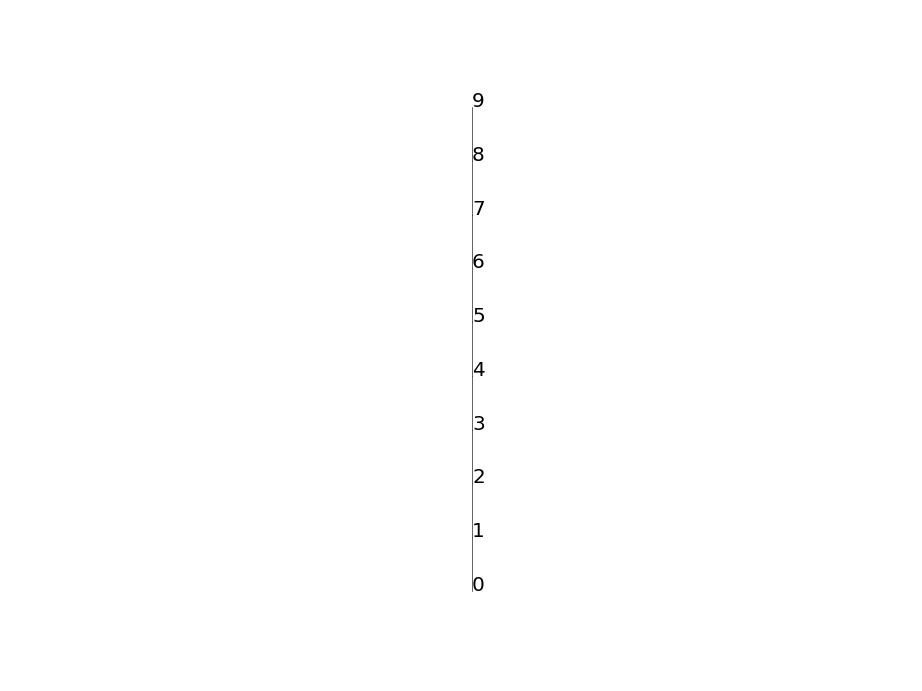

<AxesSubplot:>

In [4]:
n_floors = 9
height_floors = 3.0
width_floors = 5.0

nodes = [Node((0, 0, i*height_floors)) for i in range(n_floors+1)]
elements = [LineElement(nodes[i], nodes[i+1]) for i in range(n_floors)]

mesh_left_column = Mesh(nodes=nodes, elements=elements)
plot_mesh(mesh_left_column)

and then we create the mesh for the right column by copying the left column mesh and translate it in the x-direction by the width of the floors.

<IPython.core.display.Javascript object>


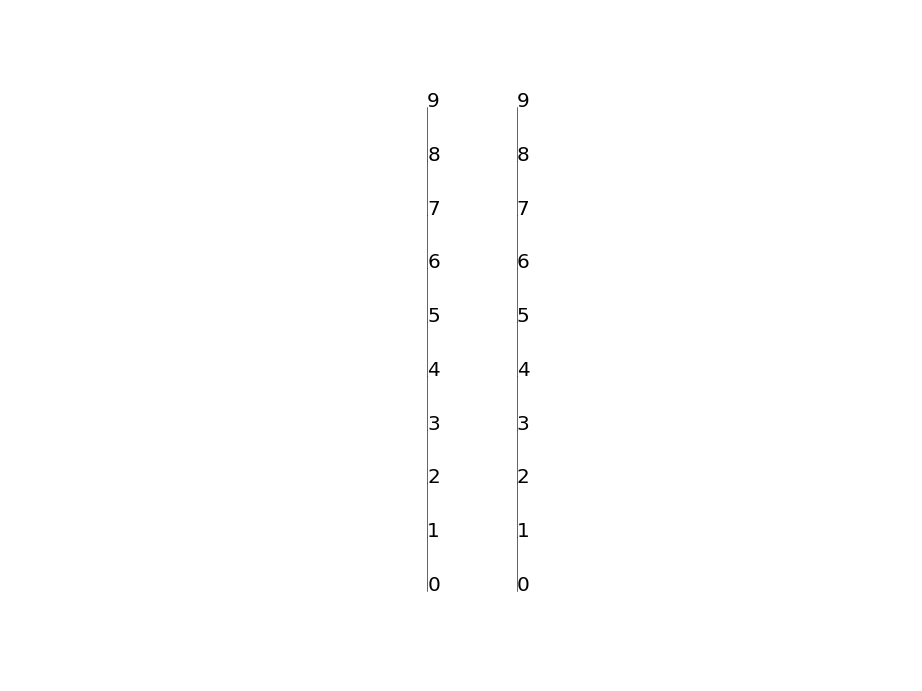

<AxesSubplot:>

In [5]:
mesh_right_column = mesh_left_column.copy()
mesh_right_column.translate((width_floors, 0., 0.))

ax = plot_mesh(mesh_left_column)
plot_mesh(mesh_right_column, ax=ax)


and finally we create the mesh for the shear frame by using the meshes from the two columns as submeshes and connecting them at the floor with line elements.

<IPython.core.display.Javascript object>


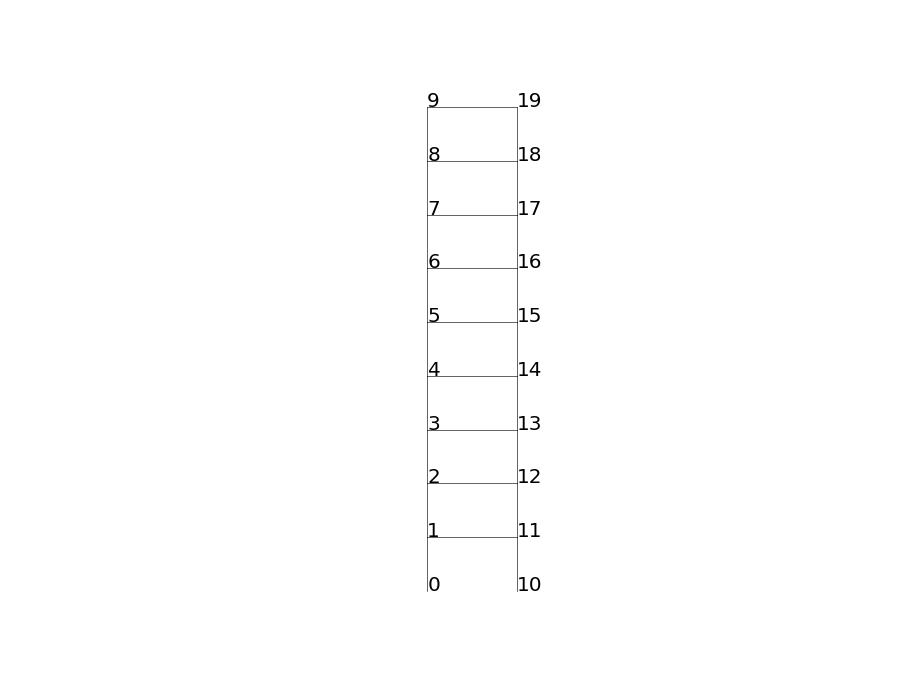

<AxesSubplot:>

In [6]:
floor_elements = [LineElement(n1, n2) 
               for n1, n2 in 
               zip(mesh_left_column.nodes[1:], mesh_right_column.nodes[1:])]
mesh_sf = Mesh(elements=floor_elements, meshes=[mesh_left_column, mesh_right_column])

plot_mesh(mesh_sf)

Note that the nodenumbers for the rightmost column has changed from 0-9 to 10-19 in the new mesh `mesh_sf` in comparison to the submesh `mesh_right_column`. In strid, the node numbers are determined by the mesh and is not a property of the node.

---

Let us assume that we have accelerometers installed at each floor, in the horizontal direction (x-direction) by the left column (x=0.0), i.e. at DOF 0 of nodes 1 to 9, see figure below:

<IPython.core.display.Javascript object>


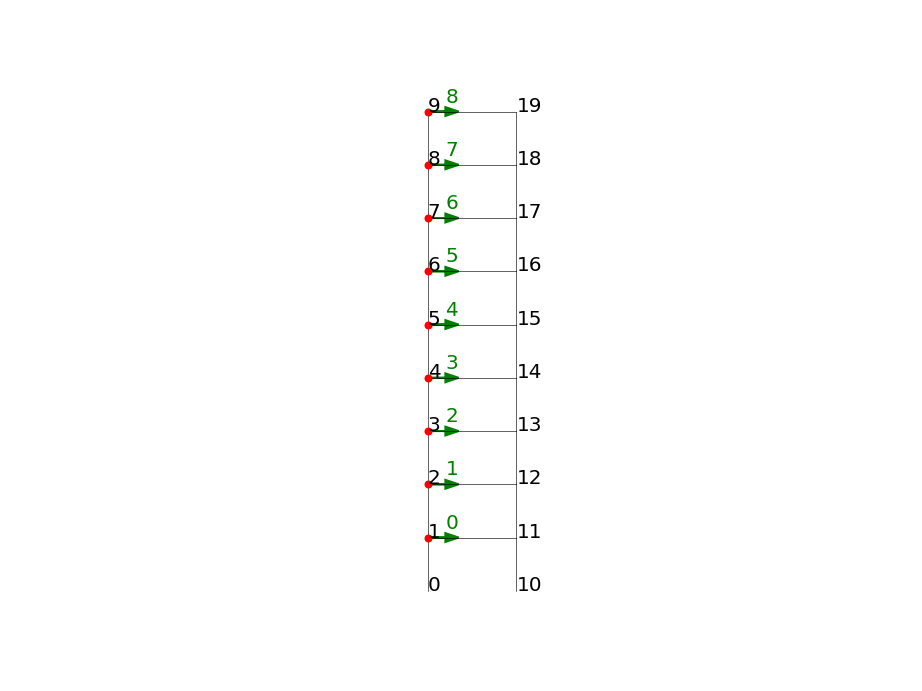

In [7]:
sensors = [mesh_sf.nodes[i].dofs[0] for i in range(1, 10)]

ax = plot_mesh(mesh_sf)
# plotting sensors
for i, sensor in enumerate(sensors):
    node = mesh_sf.find_node_by_dof(sensor)
    X = node.coordinate
    ax.plot(X[0], X[2], 'r.')
    ax.arrow(X[0], X[2], 1., 0., color='g', head_width=.5)
    ax.text(X[0]+1, X[2]+.5, f"{i}", color='g')


Given this sensor layout, our system identification will give us a mode vector which corresponds to the deformation at nodes 1 to 9 in the x-direction. The other dofs of this model must either be constrained to a predefined value or in terms of the sensor dofs.

Let us start with the out of plane dofs. This is a 2D shear frame, and all deformations out of plane (y-direction) are assumed to be zero, i.e. DOF 1 (y-direction) of nodes [0,19] has a predefined value of zero. In strid, predefined values are imposed with linear constraint equations.

In [8]:
constraints_y = []
for node in mesh_sf.nodes: # all nodes of mesh
    constraint = LinearConstraint([node.dofs[1], ], [1.,], constant=0.)
    constraints_y.append(constraint)

Next, consider the boundary conditions of the mesh. Node 0 and 10 are fixed, i.e. all dofs of these nodes are constrained to 0. Note that we already constrained dof 1 (y-direction) in the previous step, and we only have constrain dof 0 (x-direction) and 2 (z-direction) at these nodes.

In [9]:
constraints_bc = []
for nodenum in [0, 10]:
    for dofnum in [0, 2]:
        dof = mesh_sf.nodes[nodenum].dofs[dofnum]
        constraint = LinearConstraint([dof, ], [1.], constant=0.0)
        constraints_bc.append(constraint)

With our understanding of mechanical structures and elements, we know that in general, the axial deformation of a beam is negligible compared to transversal deformation. 

Considering the horizontal direction first (x-direction), this means that the free dofs in the x-direction at the right column has the same deformation as the corresponding sensor dofs at the left column. That is, the horizontal deformation of node 11 is the same as the horizontal deformation of node 1, assuming that the axial deformation of the floor between node 1 and 11 is negligible to the horizontal deformation due to bending of the columns. 

Mathematically, this can be described as

$u_{11} = u_{1}$

or equivalently 

$u_{1} - u_{11} = 0$

which again is a linear constraint equation and can be imposed in strid for the nodes at the left and right columns as

In [10]:
constraints_x = []
for nodenum_left, nodenum_right in zip(range(1, 10), range(11, 20)):
    dofx_left = mesh_sf.nodes[nodenum_left].dofs[0]
    dofx_right = mesh_sf.nodes[nodenum_right].dofs[0]
    constraint = LinearConstraint([dofx_left, dofx_right], [1., -1.], constant=0.)
    constraints_x.append(constraint)

Finally, the dofs in the vertical direction (z-direction) must be considered. Again, axial deformation is assumed to be negligible to the transversal deformation, and since nodes 0 and 10 are fixed (boundary condition), it follows that all other dofs in the vertical direction are also zero.

In [11]:
constraints_z = []
for nodenum in range(20):
    dof = mesh_sf.nodes[nodenum].dofs[2]
    constraint = LinearConstraint([dof,], [1.], constant=0.0)
    constraints_z.append(constraint)

We can now create a model of the system and check if the model is consistent, i.e. that we 
have constrained the model properly.

In [12]:
constraints = constraints_x + constraints_y + constraints_z + constraints_bc
model = SpatialModel(mesh_sf, sensors, constraints)
model.check_consistency()

StridError: Constraint error(s), non-sensor dofs must be present in one and only one constraint equation.
	Node 0, DOF 2 (z-dir) present in more than one constraint.
	Node 10, DOF 2 (z-dir) present in more than one constraint.

Ups, there is an error. The error message tells us that dof 2 (z-direction) in node 0 and 10 are involved in more than one constraint equation, i.e. there are two overconstraints. Looking back, we realize that dof 2 of node 0 and 10 has been constrained in both our handling of boundary conditions and of dofs in the z-direction.

To fix this, we rewrite the constraints in the z-direction to exclude node 0 and 10, and then redo the consistency check

In [13]:
constraints_z = []
for nodenum in range(20):
    if (nodenum == 0) or (nodenum == 10):
        continue
    dof = mesh_sf.nodes[nodenum].dofs[2]
    constraint = LinearConstraint([dof,], [1.], constant=0.0)
    constraints_z.append(constraint)
    
constraints = constraints_x + constraints_y + constraints_z + constraints_bc
model = SpatialModel(mesh_sf, sensors, constraints)
model.check_consistency()

and now the model passes the consistency check.

Note that the consistency checking can (should) be used actively when establishing the constraints of a model. The check also informs if the model is underconstrained, see below where the boundary conditions are omitted

In [14]:
constraints_wo_bc = constraints_x + constraints_y + constraints_z # + constraints_bc
model_wo_bc = SpatialModel(mesh_sf, sensors, constraints_wo_bc)
model_wo_bc.check_consistency()

StridError: Constraint error(s), non-sensor dofs must be present in one and only one constraint equation.
	Node 0, DOF 0 (x-dir) is not present in any constraint.
	Node 0, DOF 2 (z-dir) is not present in any constraint.
	Node 10, DOF 0 (x-dir) is not present in any constraint.
	Node 10, DOF 2 (z-dir) is not present in any constraint.

Now that we have a consistent model, we can convert a mode shape vector to a deformation array for the mesh. Below, we save the established model for further analysis and visualization. See [03-visualization-of-mode-shapes](03-visualization-of-mode-shapes.ipynb)

In [15]:
import pickle

with open("results/model.pkl", 'wb') as fout:
    pickle.dump(model, fout)